<a href="https://colab.research.google.com/github/alexjercan/depth-estimation/blob/master/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!pip install matplotlib==3.3.3

In [ ]:
!git clone https://github.com/alexjercan/depth-estimation.git
%cd depth-estimation

import torch
from IPython.display import clear_output

clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.8.1+cu101 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


In [ ]:
# Download bdataset
torch.hub.download_url_to_file('https://github.com/alexjercan/depth-estimation/releases/download/v1.0/bdataset_stereo.zip', 'tmp.zip')
!unzip -q tmp.zip -d ../ && rm tmp.zip

In [ ]:
torch.hub.download_url_to_file('https://github.com/alexjercan/mesh-pose-reconstruction/releases/download/v1.0/normal.pth', 'normal.pth')

In [17]:
from attr_dict import AttrDict

config_train = AttrDict()

config_train.DATASET_ROOT = "../bdataset_stereo"
config_train.JSON_PATH = "train.json"
config_train.BATCH_SIZE = 8
config_train.IMAGE_SIZE = 256
config_train.WORKERS = 8
config_train.PIN_MEMORY = True
config_train.SHUFFLE = True

config_train.LEARNING_RATE = 0.01
config_train.BETAS = [0.9, 0.999]
config_train.EPS = 0.00000001
config_train.WEIGHT_DECAY = 0.0001

config_train.MILESTONES = [10,20,30]
config_train.GAMMA = 0.2

config_train.NUM_EPOCHS = 40
config_train.TEST = False
config_train.OUT_PATH ="./runs"
config_train.LOAD_MODEL = False
config_train.SAVE_MODEL = False
config_train.CHECKPOINT_FILE = "normal.pth"

config_test = AttrDict()

config_test.DATASET_ROOT = "../bdataset_stereo"
config_test.JSON_PATH = "test.json"
config_test.BATCH_SIZE = 8
config_test.IMAGE_SIZE = 256
config_test.WORKERS = 8
config_test.PIN_MEMORY = True
config_test.SHUFFLE = False

config_test.OUT_PATH = "./runs"
config_test.LOAD_MODEL = True
config_test.CHECKPOINT_FILE = "normal.pth"

config_detect = AttrDict()

config_detect.JSON = [{"imageL": "data/left.png", "imageR": "data/right.png", "output": "data/output.exr"}]
config_detect.IMAGE_SIZE = 256
config_detect.CHECKPOINT_FILE = "normal.pth"

In [18]:
from train import train
train(config_train, config_test)

100%|██████████| 45/45 [00:12<00:00,  3.59it/s, item_losses=[0.008220328400946325, 0.015698300757341913], loss=0.0239]


In [14]:
from test import test
test(config=config_test)

100%|██████████| 45/45 [00:12<00:00,  3.58it/s, item_losses=[0.006106264123486148, 0.013292967652281126], loss=0.0194]


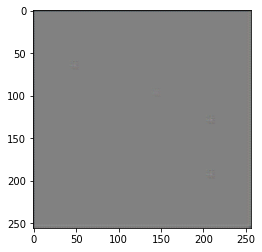

In [19]:
from detect import detect
detect(config=config_detect)

In [20]:
!git pull
!python model.py

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/alexjercan/depth-estimation
   07600c4..6d79e44  master     -> origin/master
Updating 07600c4..6d79e44
Fast-forward
 model.py   | 36 +++++++++++++++++-------------------
 train.yaml |  2 +-
 2 files changed, 18 insertions(+), 20 deletions(-)
model ok
